# Variational Autoencoder (VAE)

Useful links: 
* original paper http://arxiv.org/abs/1312.6114
* helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this seminalr we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)

You should download prepared dataset using the following link: https://yadi.sk/d/7XGFzVlrqctwT

## Prepare the data

In [59]:
import numpy as np

data = np.load("frontal_smiling_45x45.npz")
X_train = data["images"][:10000].reshape((10000,-1))
print(X_train.shape)
X_val = data["images"][10000:].reshape((-1,X_train.shape[1]))
print(X_val.shape)

image_h = data["images"].shape[1]
image_w = data["images"].shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [61]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

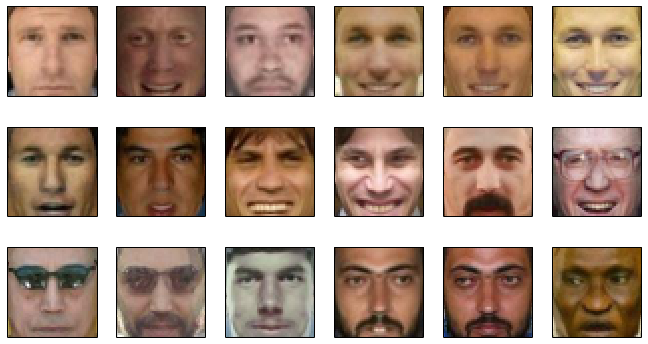

In [4]:
plot_gallery(X_train, image_h, image_w)

In [5]:
import theano
import theano.tensor as T

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [6]:
import lasagne

input_X = T.matrix("X")

input_shape = [None,image_h*image_w*3]

/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [7]:
from lasagne.init import Constant, GlorotUniform

In [8]:
HU_encoder = 400 #2000 #you can play with this values
HU_decoder = 400 #2000
dimZ = 100 #1000 #considering face reconstruction task, which size of representation seems reasonable?

l_inp = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)
#l_enc = lasagne.layers.DenseLayer(l_inp, num_units=500, nonlinearity=lasagne.nonlinearities.rectify)
l_enc = lasagne.layers.DenseLayer(l_inp, num_units=HU_encoder, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_z = lasagne.layers.DenseLayer(l_enc, num_units=dimZ, nonlinearity=lasagne.nonlinearities.rectify)
l_dec = lasagne.layers.DenseLayer(l_z, num_units=HU_decoder, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_out = lasagne.layers.DenseLayer(l_dec, num_units=image_h*image_w*3, nonlinearity=lasagne.nonlinearities.leaky_rectify)



Сначала я создала базовый автоэнкодер. В качестве нелинейности я решила пользоваться ReLu и Leaky_ReLu (на моем не очень быстром компьютере это считалось быстрее сигмоид и дало очень даже неплохой результат). 

In [15]:
# create prediction variable
prediction = lasagne.layers.get_output(l_out)

# create loss function
loss = lasagne.objectives.squared_error(prediction, input_X).mean()

# create parameter update expressions
params = lasagne.layers.get_all_params(l_out, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.001)

# compile training function that updates parameters and returns training loss
# this will take a while
train_fn = theano.function([input_X], loss, updates=updates)
test_fn = theano.function([input_X], prediction)

In [17]:
zs = lasagne.layers.get_output(l_z)
zs_fn = theano.function([input_X], zs)

In [18]:
z_X_val = zs_fn(X_val)

In [20]:
mean = np.mean(z_X_val, axis = 0)
std = np.std(z_X_val, axis = 0)

In [13]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

Итак, приступим к обучению. 

In [75]:
import time

num_epochs = 40 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, batch_size):
        inputs = batch
        train_err_batch = train_fn(inputs)
        train_err += train_err_batch
        train_batches += 1

    print train_err
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    

3.69785584629
Epoch 1 of 40 took 293.674s
1.34235736764
Epoch 2 of 40 took 283.799s
1.14102944485
Epoch 3 of 40 took 286.349s
1.01908491212
Epoch 4 of 40 took 291.629s
0.944573330228
Epoch 5 of 40 took 291.291s
0.898635938489
Epoch 6 of 40 took 291.810s
0.846485190687
Epoch 7 of 40 took 291.851s
0.812065474128
Epoch 8 of 40 took 291.368s
0.798764452595
Epoch 9 of 40 took 291.189s
0.770514018659
Epoch 10 of 40 took 291.374s
0.751906294347
Epoch 11 of 40 took 291.976s
0.737393305181
Epoch 12 of 40 took 291.499s
0.726281103166
Epoch 13 of 40 took 294.021s
0.713558431022
Epoch 14 of 40 took 291.755s
0.690713994761
Epoch 15 of 40 took 291.663s
0.696334698111
Epoch 16 of 40 took 291.783s
0.675366685737
Epoch 17 of 40 took 291.359s
0.671460088928
Epoch 18 of 40 took 289.978s
0.677620498452
Epoch 19 of 40 took 290.251s
0.664853716374
Epoch 20 of 40 took 290.434s
0.662187666316
Epoch 21 of 40 took 289.712s
0.653985074703
Epoch 22 of 40 took 290.482s
0.648140716757
Epoch 23 of 40 took 290.493s
0

Теперь посмотрим на результат. Очень неплохо. Лица более сглаженныее, нечеткие, однако весьма хорошо угадываются черты лиц.

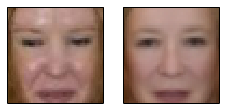

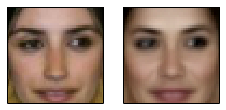

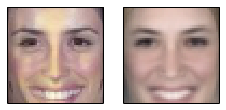

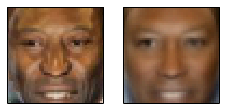

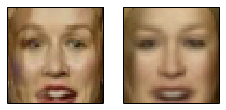

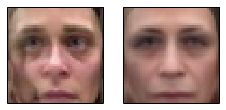

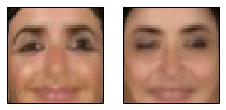

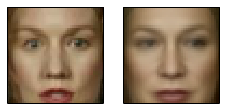

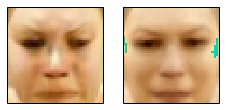

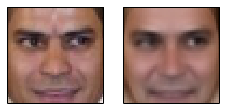

In [76]:
for batch in iterate_minibatches(X_val[:10], 1):
    pred = test_fn(batch)
    plot_gallery([batch[0],pred], image_h, image_w, n_row=1, n_col=2)

In [81]:
import pickle
all_param = lasagne.layers.get_all_params(l_out)
values = lasagne.layers.get_all_param_values(l_out)
pickle.dump(values, open("ae_param_values.pkl",'wb'))

##set_all_param_values(outlayer, values)


In [82]:
pickle.dump(all_param, open("ae_param.pkl",'wb'))

In [10]:
import pickle
values = pickle.load(open('ae_param_values.pkl')) ##['param values']
##lasagne.layers.set_all_param_values(l_out, values)

In [11]:
lasagne.layers.set_all_param_values(l_out, values)

# Sampling

This task requires deeper Lasagne knowledge. You need to perform inference from $z$, reconstruct an image given some random $z$ representations.

Теперь посмотрим, что наша нейронная сеть восстанавливает из шума.

In [85]:
all_param 

[W, b, W, b, W, b, W, b]

У меня появилась идея просто задать декодер и задать ему параметры уже обученной мной сети.

In [22]:
z = np.random.randn(25, dimZ)*0.5
ll_inp_shape = z.shape

In [23]:
z_sample = T.matrix()
#input_shape = HU_encoder 

ll_inp = lasagne.layers.InputLayer(shape = ll_inp_shape, input_var=z_sample)
ll_dec = lasagne.layers.DenseLayer(ll_inp, num_units=HU_decoder, nonlinearity=lasagne.nonlinearities.leaky_rectify)
ll_out = lasagne.layers.DenseLayer(ll_dec, num_units=image_h*image_w*3, nonlinearity=lasagne.nonlinearities.leaky_rectify)
##values_l_dec = lasagne.layers.get_value(lasagne.layers.get_params(l_dec))
##set_values(lasagne.layers.get_params(ll_dec), values_l_dec)
##values_l_out = lasagne.layers.get_value(lasagne.layers.get_params(l_out))
##set_values(lasagne.layers.get_params(ll_out), values_l_out)
# Your code goes here:


In [24]:
all_param_z = lasagne.layers.get_all_params(ll_out)

In [25]:
for p, v in zip(all_param_z, values[-4:]):
    p.set_value(v)

In [26]:
generated_x = lasagne.layers.get_output(ll_out)

gen_fn = theano.function([z_sample], generated_x)

In [27]:
generated_x = lasagne.layers.get_output(ll_out)

gen_fn = theano.function([z_sample], generated_x)

In [115]:
z = np.random.randn(25, dimZ)*0.5
ll_inp_shape = z.shape

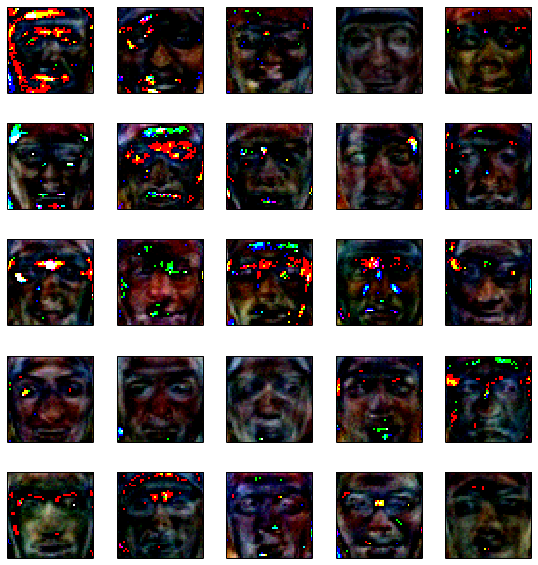

In [116]:
z = np.random.randn(25, dimZ)*0.5
output = gen_fn(np.asarray(z, dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

Получились страшные, черные лица. Хм.... Возможно это связано с тем что мы генерируем z (так было указано в ноутбуке) на отрезке [0, 0.5]. Не факт, что у нас настоящие z на l_z (среднем слое нейронной сети) имеют такое распределение.

Can you visualize how the distribution of $z$ looks like? Is it dense? What properties would we expect from it? Can we perform interpolation in $z$ space?

Уже ночью ребята посоветовали мне, как исправить ситуацию с семплингом! Конечно! Нам всего лишь надо было генерировать не случайные вектора z, а те, которые учитывают средние и ковариации! 

Хотя этого от нас напрямую и не требовалось в задании, не смогла удержаться, проснулась в 5 утра и решила доделать этот момент.

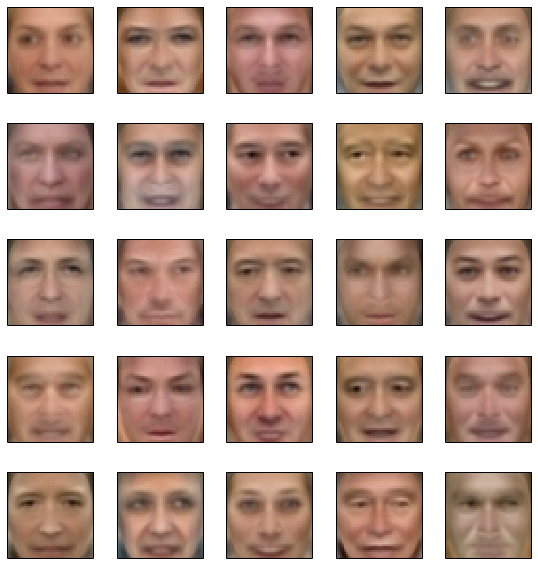

In [62]:
z = np.random.randn(25, dimZ)*std*0.5+mean
output = gen_fn(np.asarray(z, dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

Ого! Я даже и не ожидала такого хорошего результата. У нас действительно получаются лица. Весьма усредненные, абстрактные, но настоящие лица.

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution q(z|x). Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick is implemented via the **GaussianSampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon$

The code for this layer taken from "recipes" folder of Lasagne github repo:

In [12]:
import GS

import lasagne

input_X = T.matrix("X")

input_shape = [None,image_h*image_w*3]

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average like it is in Lasagne recipes.

Теперь перейдем к Variational AE. При его кодировании я пользовалась материалами, которые нашла по первой ссылке.

In [63]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before

HU_encoder = 400
HU_decoder = 400
dimZ = 100

l_var_input = lasagne.layers.InputLayer(input_shape, input_var=input_X)
l_var_enc = lasagne.layers.DenseLayer(l_var_input, HU_encoder, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_var_mu =  lasagne.layers.DenseLayer(l_var_enc, dimZ, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_var_std =  lasagne.layers.DenseLayer(l_var_enc, dimZ, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_var_z = GS.GaussianSampleLayer(l_var_mu, l_var_std)
l_var_dec =  lasagne.layers.DenseLayer(l_var_z, HU_decoder, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_var__mu =  lasagne.layers.DenseLayer(l_var_dec, image_h*image_w*3, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_var__std =  lasagne.layers.DenseLayer(l_var_dec, image_h*image_w*3, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_var_out = GS.GaussianSampleLayer(l_var__mu, l_var__std)


# define the network
# you can start from https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# or another example https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = \frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

Дааа, без подсказок из статьи мне бы здесь не обойтись.

In [64]:
def KL_divergence(mu, sigma):
    return 0.5 * T.sum(1+2*sigma-mu**2-np.exp(2*sigma))

def log_likelihood(x, mu, sigma):
    return T.sum(-(np.float32(0.5 * np.log(2 * np.pi)) + sigma)- 0.5 * np.power(x - mu,2) / np.exp(2 * sigma))

In [65]:
lasagne.layers.get_all_layers(l_var_out) # should be ~9 layers total

Now build the loss and training function:

In [66]:
# create prediction variable
pr_mu = lasagne.layers.get_output(l_var_mu)
pr_std = lasagne.layers.get_output(l_var_std)
pr__mu = lasagne.layers.get_output(l_var__mu)
pr__std = lasagne.layers.get_output(l_var__std)
pr_out = lasagne.layers.get_output(l_var_out)

# create loss function
loss_var = - KL_divergence(pr_mu, pr_std) - log_likelihood(input_X, pr__mu, pr__std)

##loss = lasagne.objectives.squared_error(prediction, input_X).mean()

# create parameter update expressions
params_var = lasagne.layers.get_all_params(l_var_out, trainable=True)
updates_var = lasagne.updates.adam(loss_var, params_var, learning_rate=0.001)

# compile training function that updates parameters and returns training loss
# this will take a while
train_fn = theano.function([input_X], loss_var, updates=updates_var)
test_fn = theano.function([input_X], pr_out)

In [67]:
mu_fn = theano.function([input_X], pr_mu)
std_fn = theano.function([input_X], pr_std)

And train the model:

Приступим к обучению (к счатью, мне выделили 5 минут поработать на GPU, я быстренько обучила нейросеть). А потом меня прогнали от GPU((( Больше я учить на нем не могу(((

In [68]:
import time

num_epochs = 50 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, batch_size):
        inputs = batch
        train_err_batch = train_fn(inputs)
        train_err += train_err_batch
        train_batches += 1

    print (train_err)
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    

111394682.219
Epoch 1 of 50 took 2.859s
57721415.8125
Epoch 2 of 50 took 2.866s
32187347.2109
Epoch 3 of 50 took 2.866s
6892939.55029
Epoch 4 of 50 took 2.865s
-8688303.05273
Epoch 5 of 50 took 2.865s
-18480644.2949
Epoch 6 of 50 took 2.865s
-26994772.9531
Epoch 7 of 50 took 2.865s
-31942032.125
Epoch 8 of 50 took 2.865s
-35843075.0547
Epoch 9 of 50 took 2.864s
-38589806.9688
Epoch 10 of 50 took 2.864s
-40806059.7812
Epoch 11 of 50 took 2.865s
-42211442.0469
Epoch 12 of 50 took 2.864s
-42985946.9688
Epoch 13 of 50 took 2.864s
-45555206.3438
Epoch 14 of 50 took 2.863s
-46649773.7656
Epoch 15 of 50 took 2.865s
-47562962.5312
Epoch 16 of 50 took 2.864s
-48407123.6719
Epoch 17 of 50 took 2.865s
-48956182.0469
Epoch 18 of 50 took 2.864s
-49445680.7969
Epoch 19 of 50 took 2.864s
-51076340.0
Epoch 20 of 50 took 2.864s
-51445267.375
Epoch 21 of 50 took 2.865s
-51326910.7031
Epoch 22 of 50 took 2.864s
-52183032.7188
Epoch 23 of 50 took 2.865s
-52429594.3594
Epoch 24 of 50 took 2.866s
-52935756.

А вот так я учила на своем ноутбуке.

In [133]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, batch_size):
        inputs = batch
        train_err_batch = train_fn(inputs)
        train_err += train_err_batch
        train_batches += 1

    print train_err
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    

74602569.8658
Epoch 1 of 10 took 149.246s
43138576.974
Epoch 2 of 10 took 144.825s
1429238.06815
Epoch 3 of 10 took 149.329s
-8387441.93763
Epoch 4 of 10 took 149.634s
-22828489.9291
Epoch 5 of 10 took 150.110s
-28028639.6019
Epoch 6 of 10 took 150.427s
-32061381.4253
Epoch 7 of 10 took 152.016s
-36210467.9768
Epoch 8 of 10 took 144.130s
-40713758.9518
Epoch 9 of 10 took 152.484s
-44378248.2642
Epoch 10 of 10 took 153.386s


Очень неплохой результат. 

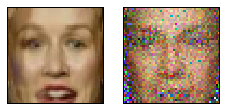

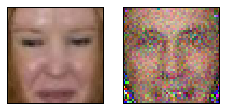

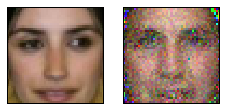

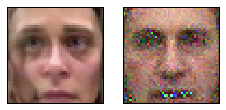

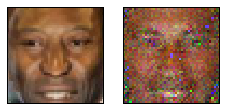

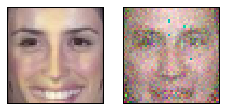

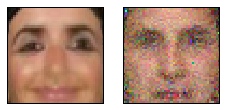

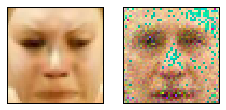

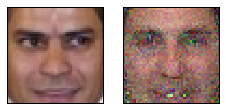

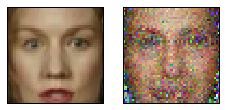

In [69]:
for batch in iterate_minibatches(X_val[:10], 1):
    pred = test_fn(batch)
    plot_gallery([batch[0],pred], image_h, image_w, n_row=1, n_col=2)

# Congrats!

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are labels in dataset, some unknown real values, face attribute. Here is the first task:

1) Sort by the attribute and find out what it is about.

In [70]:
data["labels"][:10]

array([-0.86498967,  0.79854427,  0.17281748,  0.56332728,  0.50778646,
        1.32771036, -1.25100482, -0.93904108,  1.04339486,  1.27319272])

In [71]:
sad_inds = data["labels"][10000:].argsort()[:1000]
smile_inds = data["labels"][10000:].argsort()[-1000:]

Кажется, я поняла! Лица в начале списка хмурые и грустные, а в конце - веселые.

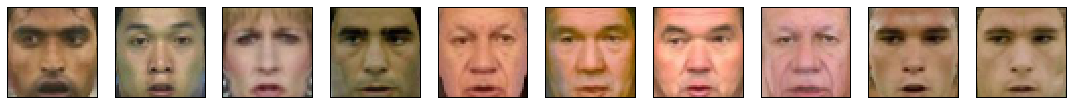

In [72]:
sads = data['images'][10000:][sad_inds]
plot_gallery(sads[:10], image_h, image_w, n_row=1, n_col=10)

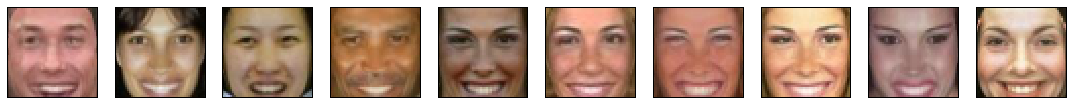

In [73]:
smiles = data['images'][10000:][smile_inds]
plot_gallery(smiles[-10:], image_h, image_w, n_row=1, n_col=10)

Попробуем поэксперементировать с фичами. План такой: возьмем 1000 веселых людей и возьмем у них средние значения для слоя mu в декодере - это быдет наша улыбка. Аналогичным образом сделаем для грустных людей - это будет наша грусть. 

In [74]:
mu_val = mu_fn(X_val)

In [75]:
sad = - np.mean(mu_val[smile_inds], axis = 0) + np.mean(mu_val[sad_inds], axis = 0)

In [76]:
smile = np.mean(mu_val[smile_inds], axis = 0) - np.mean(mu_val[sad_inds], axis = 0)

In [77]:
z_sample = T.matrix()
generated_var_x = lasagne.layers.get_output([l_var__mu], inputs={l_var_z:z_sample})
gen_var_fn = theano.function([z_sample], generated_var_x)

Опечалим веселых людей. Ух ты! Так здорово! Лица и правда стали грустными! Да еще и очки появились.

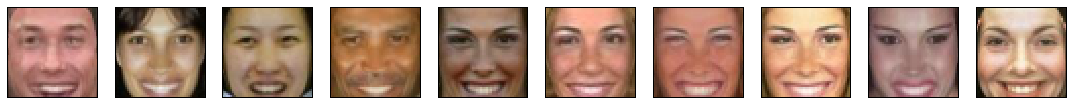

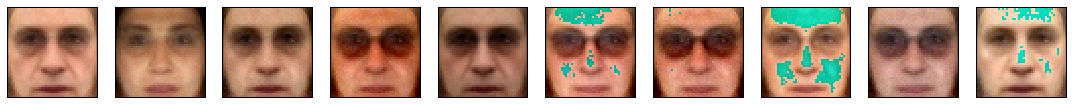

In [78]:
smiling_sad = gen_var_fn(mu_val - smile*4)
plot_gallery(smiles[-10:], image_h, image_w, 1, 10)
plot_gallery(smiling_sad[0][smile_inds[-10:].tolist()], image_h, image_w, 1, 10)

Здесь результат еще лучше! Какая улыбка! Правда слегка беззубая!

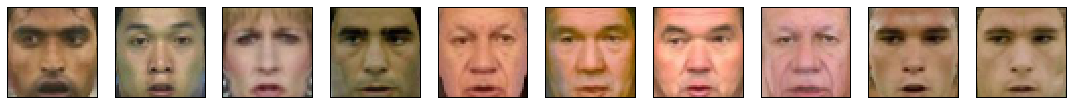

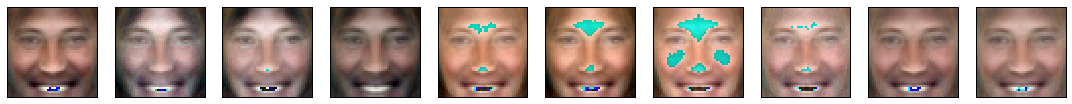

In [80]:
sad_smiling = gen_var_fn(mu_val+smile*4)
plot_gallery(sads[:10], image_h, image_w, 1, 10)
plot_gallery(sad_smiling[0][sad_inds[0:10].tolist()], image_h, image_w, 1, 10)

2) Take z-representations of those top images (you can do it only for positive of for both) and average them to find **"vector representation"** of the attribute.

3) Show how **"feature arithmetics"** works with representations of both VAE and conventional autoencoder. Show how to generate an image with preconditioned attribute. Take some sad faces and make them smiling.

4) (If you didn't manage to tune VAE, just show if it works for just AE.) Discuss the results.

<img src="linear.png" alt="linear">